In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns',100)

basket_df = pd.read_csv("./csv_files/Trans_by_Basket_50000_Cust_OA_no_XX.csv",parse_dates=[23])

print(basket_df.shape)

basket_df = basket_df.drop(columns = ['basket_id.1','time_id.1','cust_id.1','store_id.1'])

#Find an average frequency between visits?

basket_df_time = basket_df[['cust_id','shop_date']]

#asket_df_time.head(100)

#Unique_Cust = basket_df_time['cust_id'].unique()

#rint(Unique_Cust)


#for cust in Unique_Cust[1:10]:
#    excursion = basket_df_time[basket_df_time['cust_id']==cust]['shop_date']
#    print(excursion.diff)

test = pd.DataFrame(columns = ['date','diff'])

#df.groupby('item_id')['date'].diff()

test['date'] = basket_df_time.groupby('cust_id')['shop_date'].apply(lambda x: x.sort_values())
#test['diff'] = test['date'].diff() / np.timedelta64(1, 'D')

test['diff'] = test.groupby('cust_id')['date'].diff() / np.timedelta64(1, 'D')

test = test.dropna()
    
#print(test)

date_diff = test.groupby('cust_id')['diff'].agg(['min', 'max','mean'])
#test.describe()

date_diff.columns = ['shop_diff_min','shop_diff_max','shop_diff_mean']

print(date_diff.describe())

(50000, 25)
       shop_diff_min  shop_diff_max  shop_diff_mean
count     467.000000     467.000000      467.000000
mean        3.612420      93.370450       20.534571
std        23.539067     107.619889       32.568571
min         0.000000       4.000000        1.075297
25%         0.000000      27.000000        5.184189
50%         0.000000      53.000000        9.508475
75%         1.000000     112.000000       21.911688
max       308.000000     680.000000      308.000000


In [16]:
X = basket_df[['store_id','std_quantity','nunique_products',
              'n_products','sum_spend','cust_price_sensitivity',
              'basket_size', 'basket_price_sensitivity',
             'basket_type','basket_dominant_mission','store_format','store_region']]

#X['cust_lifestage'].fillna('OT')

#Groupby Customer
scaler = StandardScaler()

# Need to Dummy my variables first

X_cat = X[['cust_price_sensitivity',
              'basket_size', 'basket_price_sensitivity',
             'basket_type','basket_dominant_mission']]
X_num = X[['std_quantity','nunique_products','n_products','sum_spend']]

X_dum = pd.get_dummies(X_cat)
#X_num_scale = pd.DataFrame(scaler.fit_transform(X_num),columns=['std_quantity','nunique_products','n_products','sum_spend'])
           
X_all = pd.concat([X_num,X_dum],axis=1)

X_all = pd.concat([basket_df['cust_id'],X_all],axis=1)

X_all_cust_grp  = X_all.groupby('cust_id').agg({ 'std_quantity' : ['mean'],
                            'nunique_products' : ['mean'],
                            'n_products': ['mean'],
                            'sum_spend': ['mean','max'],
                            'cust_price_sensitivity_LA': ['max'],
                            'cust_price_sensitivity_MM': ['max'],
                            'cust_price_sensitivity_UM': ['max'],
                            'basket_size_L' : ['max', 'sum','count'],
                            'basket_size_M' : ['max', 'sum'],
                            'basket_size_S' : ['max', 'sum'],
                            'basket_price_sensitivity_LA' : ['max', 'sum'],
                            'basket_price_sensitivity_MM' : ['max', 'sum'],
                            'basket_price_sensitivity_UM' : ['max', 'sum'],
                            'basket_type_Full Shop' : ['max', 'sum'], 
                            'basket_type_Small Shop': ['max', 'sum'], 
                            'basket_type_Top Up': ['max', 'sum'],
                            'basket_dominant_mission_Fresh': ['max', 'sum'],
                            'basket_dominant_mission_Grocery': ['max', 'sum'],
                            'basket_dominant_mission_Mixed': ['max', 'sum'],
                            'basket_dominant_mission_Nonfood': ['max', 'sum'] })

X_all_cust_grp.columns = ["_".join(x) for x in X_all_cust_grp.columns.ravel()]

sum_columns = ['basket_size_L_sum', 
               'basket_size_M_sum', 
               'basket_size_S_sum', 
               'basket_price_sensitivity_LA_sum', 
               'basket_price_sensitivity_MM_sum', 
               'basket_price_sensitivity_UM_sum',
               'basket_type_Full Shop_sum', 
               'basket_type_Small Shop_sum', 
               'basket_type_Top Up_sum', 
               'basket_dominant_mission_Fresh_sum',
               'basket_dominant_mission_Grocery_sum',
               'basket_dominant_mission_Mixed_sum',
               'basket_dominant_mission_Nonfood_sum']

for col in sum_columns:
    X_all_cust_grp[col] = X_all_cust_grp[col] / X_all_cust_grp['basket_size_L_count']

X_all_cust_grp.rename(columns={"basket_size_L_count": "basket_count"})

X_all_cust_grp = pd.concat([X_all_cust_grp,date_diff],axis=1)

X_all_cust_grp.head()

X_all_cust_grp_scale = pd.DataFrame(scaler.fit_transform(X_all_cust_grp),
                                    columns=X_all_cust_grp.columns,index=X_all_cust_grp.index)

X_all_cust_grp = X_all_cust_grp[ ~X_all_cust_grp_scale.isna().any(axis=1) ] 

X_all_cust_grp_scale = X_all_cust_grp_scale.dropna()


/home/dan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [17]:
pca_grp = PCA(n_components = 0.8)

X_all_cust_grp_scale_pca = pca_grp.fit_transform(X_all_cust_grp_scale)

#plt.bar(['PC1', 'PC2','PC3','PC4'], [0:3])

#plt.xlabel('Principal Components')
#plt.ylabel('Explained Variance Ratio')

pca_grp.explained_variance_ratio_


array([0.2321431 , 0.12739852, 0.08619625, 0.06027819, 0.05808909,
       0.04765614, 0.04415864, 0.03208841, 0.02824712, 0.02745397,
       0.02407857, 0.02316172, 0.02103366])

In [18]:
import itertools

#X_all_cust_grp.drop(columns='cust_id')

model_iterator = itertools.product({'average', 'single', 'complete'}, range(2,10))

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

#X_all_cust_grp_scale = pd.DataFrame(scaler.fit_transform(X_all_cust_grp),
#                                    columns=X_all_cust_grp.columns)

agg_model_list = [ AgglomerativeClustering(affinity = 'cosine', linkage = linkage, 
                  n_clusters = number).fit(X_all_cust_grp_scale_pca) for linkage,number in model_iterator]

agg_model_sil_list = [silhouette_score(X_all_cust_grp_scale_pca,model.labels_, metric = 'cosine') for model in agg_model_list]

model_iterator = itertools.product({'average', 'single', 'complete'}, range(2,10))

agg_model_all_df = pd.DataFrame(model_iterator, columns =['linkage','n_comp'])

agg_model_all_df['sil'] = agg_model_sil_list 

#sns.catplot(x='n_comp',y='sil', hue= 'linkage',data=agg_model_all_df,kind='bar')

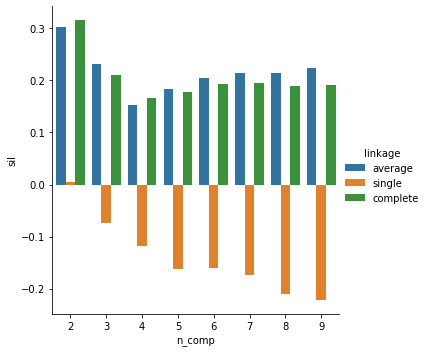

In [19]:
sns.catplot(x='n_comp',y='sil', hue= 'linkage',data=agg_model_all_df,kind='bar')

In [20]:
best_agg_model = AgglomerativeClustering(affinity = 'cosine', linkage = 'complete', 
                  n_clusters = 2).fit(X_all_cust_grp_scale_pca) 

X_zero = X_all_cust_grp_scale.iloc[best_agg_model.labels_==0]

X_one = X_all_cust_grp_scale.iloc[best_agg_model.labels_==1]

#X_two = X_all_cust_grp.iloc[best_agg_model.labels_==2]
#print(X_zero.describe().T)
#print(X_one.describe().T)

print(X_zero.shape[0])
print(X_one.shape[0])

A = (X_zero.describe().T/X_zero.shape[0] - X_one.describe().T/X_one.shape[0])*(X_zero.shape[0]+X_one.shape[0])

print(A.sort_values(by ='mean', ascending=False))

285
182
                                     count      mean       std        min  \
basket_type_Small Shop_sum             0.0  3.123751 -0.255029   1.818382   
basket_size_S_sum                      0.0  2.408010  0.205316   1.269566   
basket_size_M_sum                      0.0  2.384740 -0.618115   2.073471   
basket_dominant_mission_Grocery_sum    0.0  1.276685  0.116936   1.157630   
basket_dominant_mission_Nonfood_sum    0.0  1.083109  0.322912   0.709548   
shop_diff_max                          0.0  0.988558  0.074802   0.603835   
shop_diff_mean                         0.0  0.912814  1.037143   0.496379   
shop_diff_min                          0.0  0.484057  1.932629   0.142466   
cust_price_sensitivity_UM_max          0.0  0.133866 -0.890371   0.696914   
cust_price_sensitivity_MM_max          0.0  0.120661 -0.907445   0.765906   
basket_price_sensitivity_LA_sum        0.0  0.083834 -1.222083   0.982579   
basket_dominant_mission_Nonfood_max    0.0  0.048108 -0.953738   1.4

Text(0.5, 1.0, 'Mean Differences Between Groups (Scaled)')

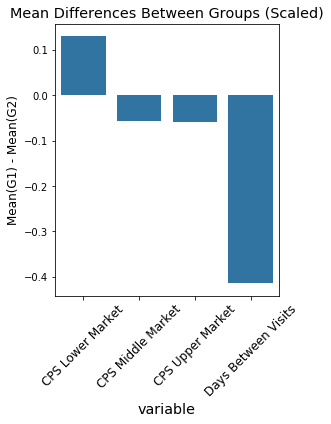

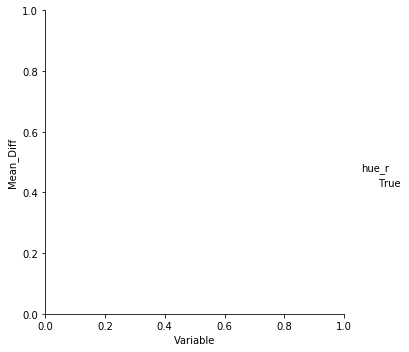

In [32]:
#Bar plot of above....
import scipy.stats as stats

results = [] ; 

test_index = ['cust_price_sensitivity_LA_max',
            'cust_price_sensitivity_MM_max',
            'cust_price_sensitivity_UM_max',
              'shop_diff_mean',
            ]
for var in test_index:
    
    mean_diff = X_zero[var].mean() - X_one[var].mean()

    results.append([var,X_zero[var].mean(),X_one[var].mean(), -1*mean_diff, stats.f_oneway(X_zero[var], X_one[var])[0],stats.f_oneway(X_zero[var], X_one[var])[1] ])

results_df = pd.DataFrame(results,columns = ['Variable','Group_1_mean','Group_2_mean','Mean_Diff','Fstat','P_value'])

results_df = results_df.sort_values(by = 'Mean_Diff', ascending=False)

results_df['hue_r'] = results_df['Mean_Diff']<3

#plt.rcParams["figure.figsize"] = (8=20, 4)
fig_dims = (4, 5)
fig, ax = plt.subplots(figsize=fig_dims)
chart = sns.catplot(x='Variable',y='Mean_Diff',data=results_df,hue='hue_r',kind='bar', ax=ax)
ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xticklabels(['CPS Lower Market','CPS Middle Market','CPS Upper Market','Days Between Visits'],fontsize='large')
ax.set_xlabel('variable',fontsize='x-large')
ax.set_ylabel('Mean(G1) - Mean(G2)',fontsize='large')
ax.set_title('Mean Differences Between Groups (Scaled)',fontsize='x-large')


In [22]:
results_df

,Variable,Group_1_mean,Group_2_mean,Mean_Diff,Fstat,P_value,hue_r
3,cust_price_sensitivity_LA_max,-0.046115,0.084345,0.130460,1.878753,0.171137,True
2,cust_price_sensitivity_MM_max,0.024489,-0.031386,-0.055875,0.345172,0.557144,True
0,cust_price_sensitivity_UM_max,0.015589,-0.042215,-0.057804,0.371339,0.542573,True
1,shop_diff_mean,0.161369,-0.252694,-0.414063,19.767330,0.000011,True


In [23]:


X_all_cust_grp.head()


,std_quantity_mean,nunique_products_mean,n_products_mean,sum_spend_mean,sum_spend_max,cust_price_sensitivity_LA_max,cust_price_sensitivity_MM_max,cust_price_sensitivity_UM_max,basket_size_L_max,basket_size_L_sum,basket_size_L_count,basket_size_M_max,basket_size_M_sum,basket_size_S_max,basket_size_S_sum,basket_price_sensitivity_LA_max,basket_price_sensitivity_LA_sum,basket_price_sensitivity_MM_max,basket_price_sensitivity_MM_sum,basket_price_sensitivity_UM_max,basket_price_sensitivity_UM_sum,basket_type_Full Shop_max,basket_type_Full Shop_sum,basket_type_Small Shop_max,basket_type_Small Shop_sum,basket_type_Top Up_max,basket_type_Top Up_sum,basket_dominant_mission_Fresh_max,basket_dominant_mission_Fresh_sum,basket_dominant_mission_Grocery_max,basket_dominant_mission_Grocery_sum,basket_dominant_mission_Mixed_max,basket_dominant_mission_Mixed_sum,basket_dominant_mission_Nonfood_max,basket_dominant_mission_Nonfood_sum,shop_diff_min,shop_diff_max,shop_diff_mean
CUST0000009737,0.399631,4.979452,7.147260,8.873973,80.23,0,1,0,1,0.215753,292,1,0.445205,1,0.339041,1,0.082192,1,0.818493,1,0.099315,1,0.051370,1,0.750000,1,0.198630,1,0.386986,1,0.113014,1,0.226027,1,0.273973,0.0,28.0,1.632302
CUST0000010532,0.248033,3.040000,4.240000,5.248800,15.72,0,1,0,1,0.080000,25,1,0.520000,1,0.400000,1,0.120000,1,0.680000,1,0.200000,0,0.000000,1,0.760000,1,0.240000,1,0.640000,1,0.240000,1,0.120000,0,0.000000,0.0,293.0,31.541667
CUST0000010950,0.466178,4.504854,6.864078,10.574951,35.10,0,0,1,1,0.252427,103,1,0.563107,1,0.184466,1,0.019417,1,0.213592,1,0.766990,0,0.000000,1,0.466019,1,0.533981,1,0.582524,1,0.213592,1,0.194175,1,0.009709,0.0,26.0,5.431373
CUST0000012470,0.523423,7.000000,8.750000,11.736250,29.96,0,1,0,1,0.375000,16,1,0.437500,1,0.187500,1,0.062500,1,0.562500,1,0.375000,1,0.062500,1,0.562500,1,0.375000,1,0.625000,1,0.250000,1,0.125000,0,0.000000,1.0,56.0,12.266667
CUST0000014549,0.156832,4.505882,4.945098,6.953902,40.78,1,0,0,1,0.090196,510,1,0.713725,1,0.196078,1,0.592157,1,0.366667,1,0.041176,1,0.005882,1,0.609804,1,0.384314,1,0.354902,1,0.249020,1,0.362745,1,0.033333,0.0,8.0,1.599214


In [24]:

X_zero_p = X_all_cust_grp.iloc[best_agg_model.labels_==0]

X_one_p = X_all_cust_grp.iloc[best_agg_model.labels_==1]

print('Group_0 total spend',(X_zero_p['sum_spend_mean']*X_zero_p['basket_size_L_count']).sum())
print('Group_1 total spend',(X_one_p['sum_spend_mean']*X_one_p['basket_size_L_count']).sum())

Group_0 total spend 194982.55
Group_1 total spend 359823.33999999997


In [25]:
print(X_zero.shape[0])
print(X_one.shape[0])

285
182


In [26]:
results_df.head()


,Variable,Group_1_mean,Group_2_mean,Mean_Diff,Fstat,P_value,hue_r
3,cust_price_sensitivity_LA_max,-0.046115,0.084345,0.130460,1.878753,0.171137,True
2,cust_price_sensitivity_MM_max,0.024489,-0.031386,-0.055875,0.345172,0.557144,True
0,cust_price_sensitivity_UM_max,0.015589,-0.042215,-0.057804,0.371339,0.542573,True
1,shop_diff_mean,0.161369,-0.252694,-0.414063,19.767330,0.000011,True


In [27]:
print(results_df['Variable'] == 'basket_type_Small Shop_sum')

3    False
2    False
0    False
1    False
Name: Variable, dtype: bool


In [28]:
results_df['Variable'] == ["basket_size_S_sum"]

ValueError: Lengths must match to compare

In [ ]:
hue_r